In [28]:
import pandas as pd
import nltk
import re
from nltk.tokenize import sent_tokenize

# --- KONFIGURATION & SETUP ---
OUTPUT_FILE = "output.csv"
ENTITIES_FILE = "2entities_to_edit.csv"
STATS_FILENAME = "master_statistics_full.csv"

# Versuche NLTK zu laden, setze Flag für Fallback wenn offline
try:
    nltk.data.find('tokenizers/punkt')
    nltk_available = True
except LookupError:
    # Automatischer Download Versuch
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('punkt_tab', quiet=True)
        nltk_available = True
    except:
        nltk_available = False
        print("⚠️ Warnung: NLTK Daten nicht verfügbar. Nutze einfachen Fallback-Tokenizer.")

def robust_sentence_count(text):
    """Zählt Sätze robust, egal ob NLTK installiert ist oder nicht."""
    if not isinstance(text, str) or not text.strip():
        return 0
    if nltk_available:
        try:
            return len(sent_tokenize(text))
        except:
            pass # Fallback bei unerwartetem NLTK Fehler
    # Fallback: Split bei Satzzeichen (.?!) gefolgt von Leerzeichen
    return len(re.split(r'[.?!]\s+', text))

# --- 1. DATEN LADEN ---
try:
    output_df = pd.read_csv(OUTPUT_FILE)
    entities_df = pd.read_csv(ENTITIES_FILE)
except FileNotFoundError as e:
    print(f"❌ Kritischer Fehler: Datei nicht gefunden ({e})")
    exit()

# --- 2. BASIS-STATISTIKEN (Dokumente & Paragraphen) ---
if not output_df.empty:
    output_df['char_count'] = output_df['text'].fillna('').str.len()
    
    # Aggregation auf Länderebene
    stats_base = output_df.groupby('Country').agg(
        Documents=('Doc_ID', 'nunique'),
        Total_Paragraphs=('Paragraph_ID', 'count'),
        Total_Characters=('char_count', 'sum')
    ).reset_index()

    # --- 3. AKTEURS-STATISTIKEN (Entities) ---
    valid_qh = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered_entities = entities_df[entities_df['qh_category'].isin(valid_qh)]
    
    # Zählen und Mergen
    entity_counts = filtered_entities.groupby('Country').size().reset_index(name='Total_QH_Actors')
    master_table = pd.merge(stats_base, entity_counts, on='Country', how='left').fillna(0)
    master_table['Total_QH_Actors'] = master_table['Total_QH_Actors'].astype(int)

    # --- 4. ADVANCED STATISTIKEN (Satz-Ebene) ---
    output_df['sentence_count'] = output_df['text'].apply(robust_sentence_count)
    
    # Summe der Sätze pro Land
    sent_stats = output_df.groupby('Country')['sentence_count'].sum().reset_index(name='Total_Sentences')
    master_table = pd.merge(master_table, sent_stats, on='Country', how='left')

    # --- 5. ABGELEITETE METRIKEN BERECHNEN ---
    # Durchschnittliche Zeichen pro Satz (Komplexität)
    master_table['Avg_Chars_per_Sentence'] = master_table['Total_Characters'] / master_table['Total_Sentences']
    
    # Durchschnittliche Sätze pro Paragraph (Struktur)
    master_table['Avg_Sentences_per_Para'] = master_table['Total_Sentences'] / master_table['Total_Paragraphs']
    
    # Akteurs-Dichte (Wie viele Akteure kommen auf 100 Sätze?)
    master_table['Actors_per_100_Sentences'] = (master_table['Total_QH_Actors'] / master_table['Total_Sentences']) * 100

    # Bereinigung von möglichen Teilungs-Fehlern (Division by Zero)
    master_table = master_table.fillna(0)

    # --- 6. AUSGABE & SPEICHERN ---
    pd.options.display.float_format = '{:,.2f}'.format
    
    print("\n--- 1. Master Statistics ---")
    print(master_table.to_string(index=False))
    
    master_table.to_csv(STATS_FILENAME, index=False)
else:
    print("Keine Daten zum Verarbeiten vorhanden.")


--- 1. Master Statistics ---
Country  Documents  Total_Paragraphs  Total_Characters  Total_QH_Actors  Total_Sentences  Avg_Chars_per_Sentence  Avg_Sentences_per_Para  Actors_per_100_Sentences
    CAN          1               147             84942               97              487                  174.42                    3.31                     19.92
    GER          1               172            139300              169              810                  171.98                    4.71                     20.86
     UK          1               161            134319              144              688                  195.23                    4.27                     20.93
    USA          1                48             44202               41              228                  193.87                    4.75                     17.98


In [35]:
try:
    entities_df = pd.read_csv("2entities_to_edit.csv")
    valid_qh = ['Academia', 'Government', 'Industry', 'Civil Society']
    
    # Filter & Count
    filtered = entities_df[entities_df['qh_category'].isin(valid_qh)]
    actor_stats = filtered.groupby(['Country', 'qh_category']).size().unstack(fill_value=0)
    
    # Add Total column
    actor_stats['Total_Actors'] = actor_stats.sum(axis=1)
    
    print("--- 2. ACTOR DISTRIBUTION ---")
    print(actor_stats)

except FileNotFoundError:
    print("Error: '2entities_to_edit.csv' not found.")

--- 2. ACTOR DISTRIBUTION ---
qh_category  Academia  Civil Society  Government  Industry  Total_Actors
Country                                                                 
CAN                16              8          66         7            97
GER                84             19          36        30           169
UK                 39             24          60        21           144
USA                 2              1          38         0            41


In [34]:
import numpy as np

def calculate_entropy(df):
    # Anteil jeder Kategorie berechnen
    counts = df['qh_category'].value_counts(normalize=True)
    # Shannon Entropie Formel: -sum(p * log(p))
    entropy = -np.sum(counts * np.log2(counts + 1e-9)) # +1e-9 verhindert log(0)
    return entropy

try:
    entities_df = pd.read_csv("2entities_to_edit.csv")
    valid_qh = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered = entities_df[entities_df['qh_category'].isin(valid_qh)]
    
    # Entropie pro Land berechnen
    balance_score = filtered.groupby('Country').apply(calculate_entropy).reset_index(name='Ecosystem_Balance_Score')
    
    print("--- 3. ÖKOSYSTEM-BALANCE ---")
    print(balance_score.sort_values('Ecosystem_Balance_Score', ascending=False).round(3))

except FileNotFoundError:
    print("Fehler: 2entities_to_edit.csv nicht gefunden.")

--- 3. ÖKOSYSTEM-BALANCE ---
  Country  Ecosystem_Balance_Score
2      UK                     1.87
1     GER                     1.77
0     CAN                     1.38
3     USA                     0.45


C:\Users\user\AppData\Local\Temp\ipykernel_10204\3679574777.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balance_score = filtered.groupby('Country').apply(calculate_entropy).reset_index(name='Ecosystem_Balance_Score')


In [33]:
import pandas as pd

# 1. DATEN LADEN
try:
    df = pd.read_csv("2entities_to_edit.csv")
    
    # 2. FILTERN
    valid_qh = ['Academia', 'Government', 'Industry', 'Civil Society']
    
    # Sicherstellen, dass die Spalten existieren
    if 'qh_category' in df.columns and 'qh_sub_category' in df.columns:
        filtered = df[df['qh_category'].isin(valid_qh)].copy()
        
        # Leere Sub-Kategorien füllen
        filtered['qh_sub_category'] = filtered['qh_sub_category'].fillna('Unspecified')
        
        # 3. ZÄHLEN & SORTIEREN
        stats = filtered.groupby(['qh_category', 'qh_sub_category']).size().reset_index(name='Frequency')
        stats = stats.sort_values(by=['qh_category', 'Frequency'], ascending=[True, False])
        
        # 4. HIERARCHISCHE AUSGABE
        print("\n--- 4. HIERARCHISCHE SUB-KATEGORIEN STATISTIK ---")
        
        current_cat = None
        for _, row in stats.iterrows():
            cat = row['qh_category']
            sub = row['qh_sub_category']
            freq = row['Frequency']
            
            # Gruppen-Header (Hauptkategorie)
            if cat != current_cat:
                cat_total = stats[stats['qh_category'] == cat]['Frequency'].sum()
                print(f"\n📂 {cat.upper()} (Gesamt: {cat_total})")
                current_cat = cat
            
            # Subkategorie mit Prozentanteil
            pct = (freq / cat_total) * 100
            bar = "█" * int(pct / 5) # ASCII Balken für Visualisierung
            print(f"   ├── {sub}: {freq} ({pct:.1f}%) {bar}")

        # CSV speichern
        stats.to_csv("hierarchical_subcategories.csv", index=False)
        
    else:
        print("❌ Spalten 'qh_category' oder 'qh_sub_category' fehlen.")

except FileNotFoundError:
    print("❌ Datei '2entities_to_edit.csv' nicht gefunden.")


--- 4. HIERARCHISCHE SUB-KATEGORIEN STATISTIK ---

📂 ACADEMIA (Gesamt: 141)
   ├── Public Research Orgs (PROs): 112 (79.4%) ███████████████
   ├── Higher Education Institutions (HEIs): 25 (17.7%) ███
   ├── Research Consortium: 3 (2.1%) 
   ├── Education & Skills Provider: 1 (0.7%) 

📂 CIVIL SOCIETY (Gesamt: 52)
   ├── Intermediaries: 52 (100.0%) ████████████████████

📂 GOVERNMENT (Gesamt: 200)
   ├── Policy Makers: 70 (35.0%) ███████
   ├── Funding Agencies: 38 (19.0%) ███
   ├── Federal Agency: 28 (14.0%) ██
   ├── Public Research ORGs (PRO): 18 (9.0%) █
   ├── Government Support Services: 13 (6.5%) █
   ├── Intergovernmental Organization: 13 (6.5%) █
   ├── Bank: 4 (2.0%) 
   ├── Regulatory Agency: 4 (2.0%) 
   ├── Public Research Orgs (PROs): 3 (1.5%) 
   ├── Federal Research Organization: 2 (1.0%) 
   ├── National Intelligence Agency: 2 (1.0%) 
   ├── Strategic Defense Partnership: 2 (1.0%) 
   ├── Governent Support Service: 1 (0.5%) 
   ├── Public Administration: 1 (0.5%) 
   ├─

Loaded entities: 648 rows.


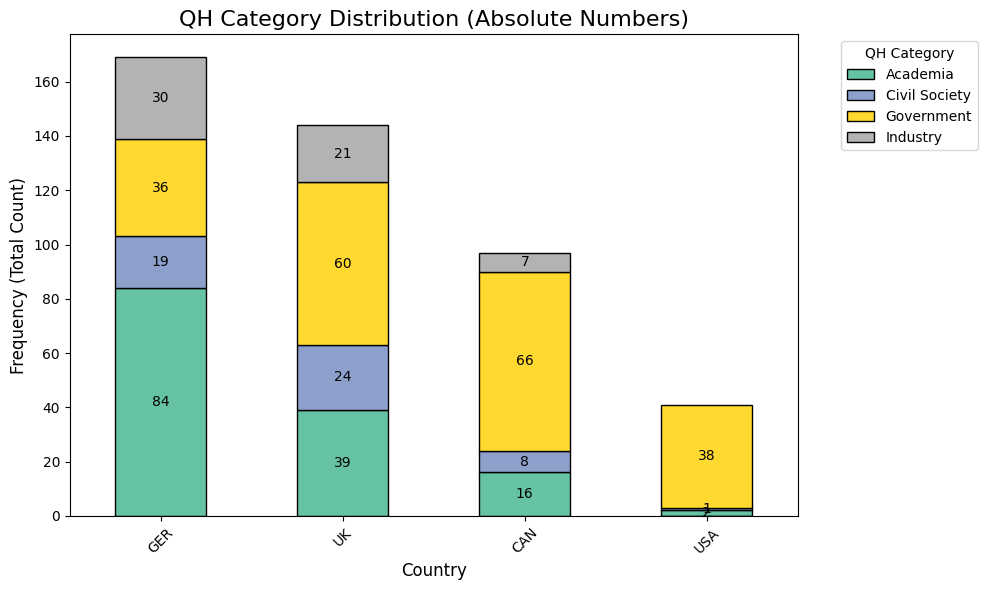

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. LOAD DATA
try:
    entities_df = pd.read_csv("2entities_to_edit.csv")
    print(f"Loaded entities: {len(entities_df)} rows.")
except FileNotFoundError:
    print("Error: '2entities_to_edit.csv' not found.")
    entities_df = pd.DataFrame()

if not entities_df.empty:
    # 2. FILTER FOR QH ACTORS ONLY
    valid_qh_actors = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered_df = entities_df[entities_df['qh_category'].isin(valid_qh_actors)].copy()
    
    if filtered_df.empty:
        print("Alert: No data remained after filtering.")
    else:
        # 3. VISUALIZE
        # Group by Country and QH Category
        counts = filtered_df.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')

        # Pivot for the stacked chart
        pivot_df = counts.pivot_table(
            index='Country', 
            columns='qh_category', 
            values='Frequency', 
            aggfunc='sum'
        ).fillna(0)
        
        # Sort by volume
        pivot_df['Total'] = pivot_df.sum(axis=1)
        pivot_df = pivot_df.sort_values('Total', ascending=False).drop(columns='Total')
        
        # Plot
        ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2', edgecolor='black')
        
        # --- NEU: ABSOLUTE ZAHLEN HINZUFÜGEN ---
        for c in ax.containers:
            # Wir zeigen die Zahl nur an, wenn sie größer als 0 ist
            labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', fontsize=10)

        plt.title('QH Category Distribution (Absolute Numbers)', fontsize=16)
        plt.xlabel('Country', fontsize=12)
        plt.ylabel('Frequency (Total Count)', fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title='QH Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

else:
    print("No data loaded.")

Geladen: 648 Zeilen.


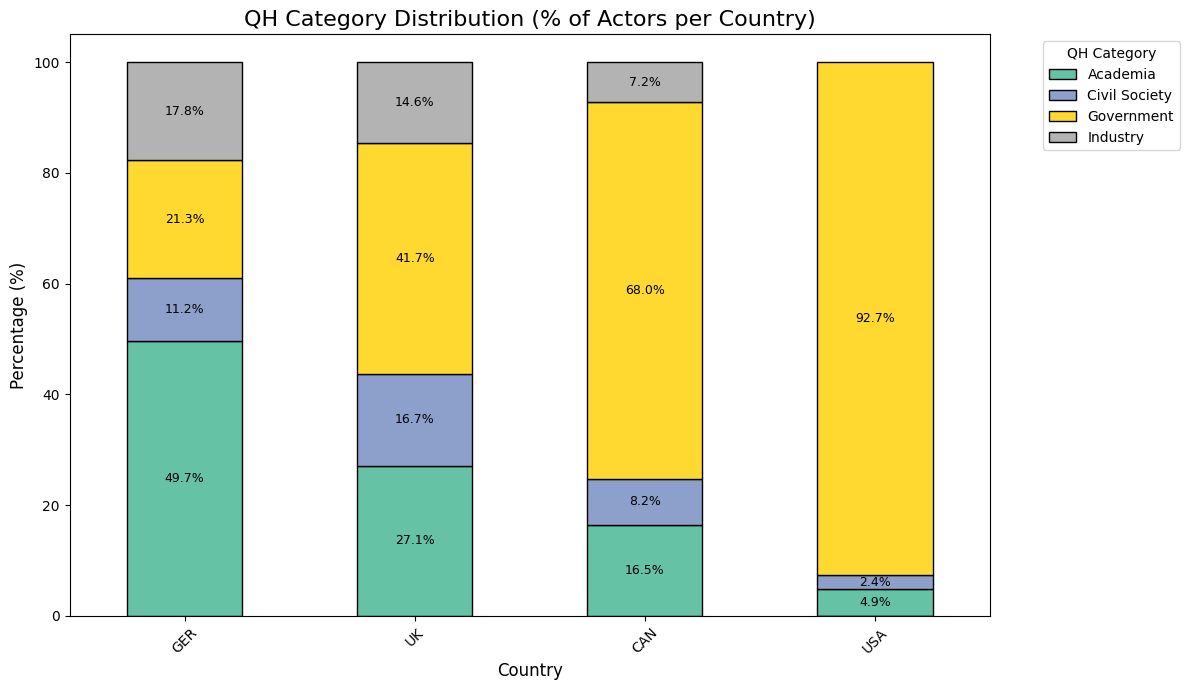

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. DATEN LADEN
try:
    entities_df = pd.read_csv("2entities_to_edit.csv")
    print(f"Geladen: {len(entities_df)} Zeilen.")
except FileNotFoundError:
    print("Fehler: '2entities_to_edit.csv' nicht gefunden.")
    entities_df = pd.DataFrame()

if not entities_df.empty:
    # 2. FILTERN
    valid_qh_actors = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered_df = entities_df[entities_df['qh_category'].isin(valid_qh_actors)].copy()
    
    if filtered_df.empty:
        print("Keine Daten nach Filterung übrig.")
    else:
        # 3. DATEN VORBEREITEN
        counts = filtered_df.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')
        pivot_df = counts.pivot_table(
            index='Country', 
            columns='qh_category', 
            values='Frequency', 
            aggfunc='sum'
        ).fillna(0)
        
        # In Prozent umrechnen
        pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
        
        # Sortieren nach Gesamtanzahl der Akteure (optional)
        total_counts = pivot_df.sum(axis=1).sort_values(ascending=False)
        pivot_df_percent = pivot_df_percent.reindex(total_counts.index)
        
        # 4. VISUALISIERUNG
        ax = pivot_df_percent.plot(
            kind='bar', 
            stacked=True, 
            figsize=(12, 7), 
            colormap='Set2', 
            edgecolor='black'
        )
        
        # --- NEU: PROZENTZAHLEN HINZUFÜGEN ---
        for c in ax.containers:
            # Wir zeigen das Label nur an, wenn der Wert > 0 ist, um Überlappungen zu vermeiden
            labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

        plt.title('QH Category Distribution (% of Actors per Country)', fontsize=16)
        plt.xlabel('Country', fontsize=12)
        plt.ylabel('Percentage (%)', fontsize=12)
        plt.xticks(rotation=45)
        plt.ylim(0, 105) # Etwas Platz nach oben lassen
        
        plt.legend(title='QH Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

Daten geladen. Entities: 648, Text-Abschnitte: 528


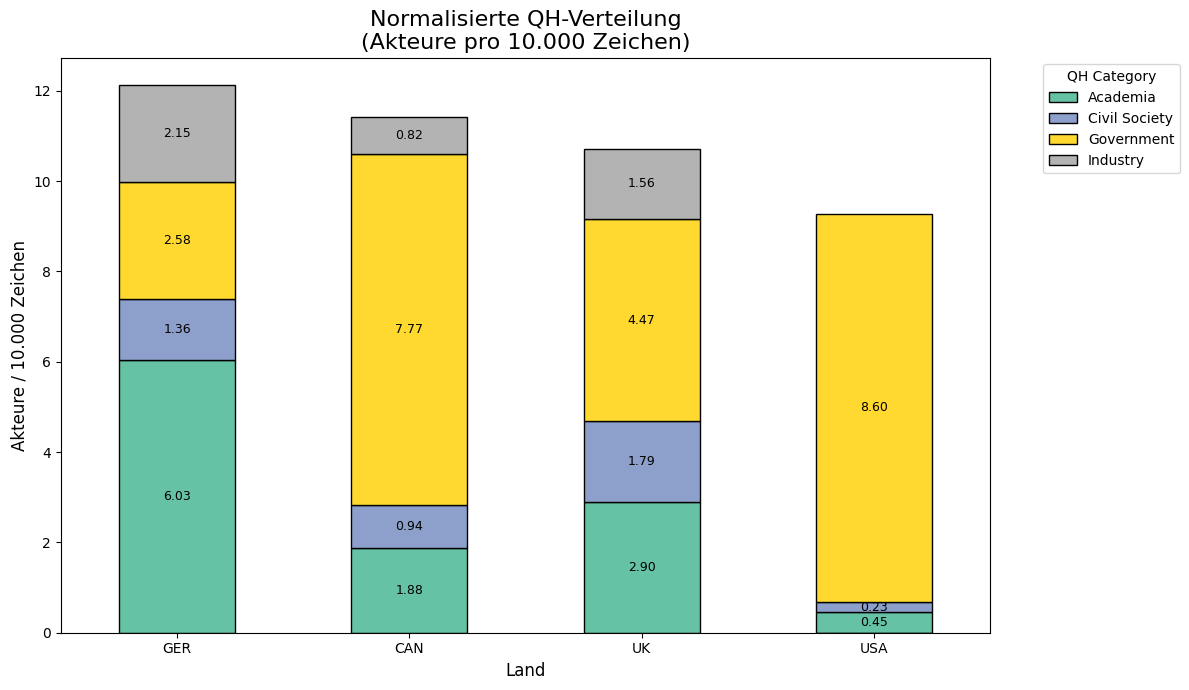

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. DATEN LADEN
try:
    entities_df = pd.read_csv("2entities_to_edit.csv")
    output_df = pd.read_csv("output.csv")
    print(f"Daten geladen. Entities: {len(entities_df)}, Text-Abschnitte: {len(output_df)}")
except FileNotFoundError as e:
    print(f"Fehler: {e}")
    entities_df = pd.DataFrame()
    output_df = pd.DataFrame()

if not entities_df.empty and not output_df.empty:
    # 2. TEXTLÄNGE PRO LAND BERECHNEN (aus output.csv)
    # Wir summieren die Zeichenanzahl aller Texte pro Land
    output_df['text_len'] = output_df['text'].fillna('').str.len()
    country_lengths = output_df.groupby('Country')['text_len'].sum().reset_index()
    country_lengths.rename(columns={'text_len': 'total_text_length'}, inplace=True)
    
    # 3. FILTER FÜR QH AKTEURE
    valid_qh_actors = ['Academia', 'Government', 'Industry', 'Civil Society']
    filtered_df = entities_df[entities_df['qh_category'].isin(valid_qh_actors)].copy()
    
    # 4. ABSOLUTE ANZAHLEN BERECHNEN
    counts = filtered_df.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')
    
    # 5. ZUSAMMENFÜHREN UND NORMALISIEREN
    # Normalisierung: (Anzahl / Gesamtzeichen) * 10.000
    merged = pd.merge(counts, country_lengths, on='Country')
    merged['Normalized_Freq'] = (merged['Frequency'] / merged['total_text_length']) * 10000
    
    # 6. PIVOT-TABELLE FÜR DIE GRAFIK
    pivot_df = merged.pivot_table(
        index='Country', 
        columns='qh_category', 
        values='Normalized_Freq', 
        aggfunc='sum'
    ).fillna(0)
    
    # Sortieren nach der gesamten normalisierten Dichte
    pivot_df['Total_Norm'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values('Total_Norm', ascending=False).drop(columns='Total_Norm')
    
    # 7. VISUALISIERUNG
    ax = pivot_df.plot(
        kind='bar', 
        stacked=True, 
        figsize=(12, 7), 
        colormap='Set2', 
        edgecolor='black'
    )
    
    # Beschriftungen hinzufügen (2 Dezimalstellen)
    for c in ax.containers:
        labels = [f'{v.get_height():.2f}' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=9)
    
    plt.title('Normalisierte QH-Verteilung\n(Akteure pro 10.000 Zeichen)', fontsize=16)
    plt.xlabel('Land', fontsize=12)
    plt.ylabel('Akteure / 10.000 Zeichen', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='QH Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # Optional: Die normalisierten Daten speichern
    pivot_df.to_csv("normalized_actor_counts.csv")
else:
    print("Daten konnten nicht verarbeitet werden.")